## Brain Tumor Detection from MRI Images using Convolutional Neural Networks (CNNs)

**Goal**: The goal of this project is to develop a deep learning model based on Convolutional Neural Networks (CNNs) that can automatically classify brain MRI scans into two categories: tumor and no tumor. By leveraging image processing and deep learning techniques, the model aims to assist in early and accurate detection of brain tumors, which can support radiologists and improve medical decision-making.

In [1]:
#needed libraries
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image
import hashlib
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2
import warnings
warnings.filterwarnings('ignore')



In [2]:
#image settings
img_size = (224, 224)   
batch_size = 32

# Load datasets
dataset = tf.keras.utils.image_dataset_from_directory(
    "brain_tumor_dataset",
    image_size=img_size,
    batch_size=batch_size)

# resize images and normalize pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = dataset.map(lambda x, y: (normalization_layer(x), y))

print("classes:",dataset.class_names)

Found 253 files belonging to 2 classes.
classes: ['no', 'yes']


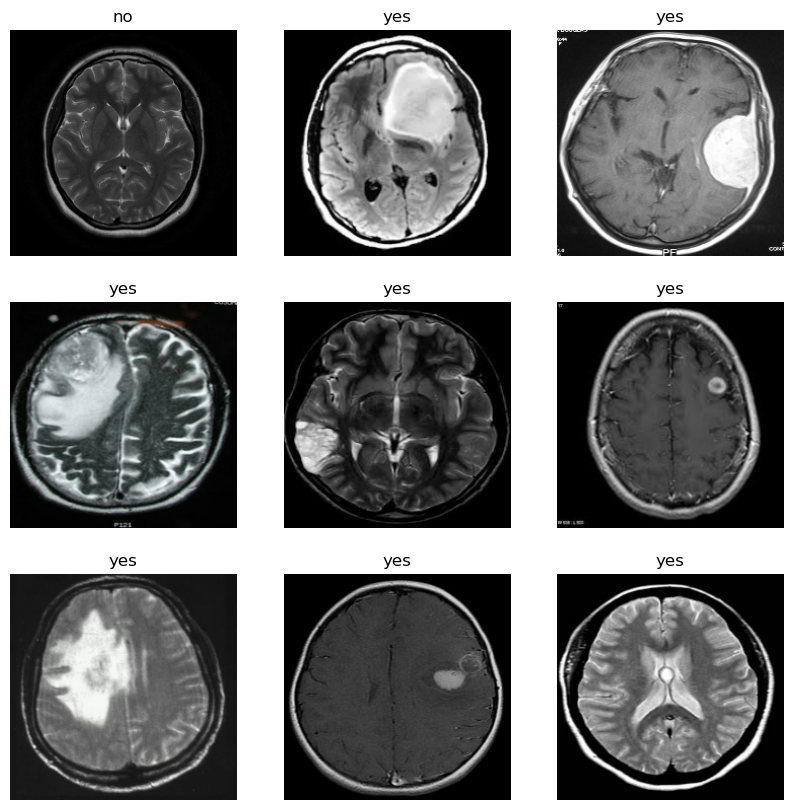

In [3]:
for images, labels in dataset.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9): #show 9 images
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(dataset.class_names[labels[i]])
        plt.axis("off")
    plt.show()

Insight

- The "yes" Scans (Anomalous): Consistently show a distinct, clearly visible mass or lesion (likely a tumor) within the brain tissue.

- The "no" Scans (Normal): Show normal brain anatomy without any obvious tumors or space-occupying lesions.

**Data Preprocessing**

In [4]:
# check for corrupted images
num_skipped = 0
for folder_name in ("no", "yes"):
    folder_path = os.path.join("brain_tumor_dataset", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)


Deleted 13 images


In [5]:
# check for duplicated images
image_hashes = set()
duplicate = 0
for folder_name in ("no", "yes"):
    folder_path = os.path.join("brain_tumor_dataset", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        img = Image.open(fpath)
        img = img.resize(img_size)
        img_array = np.array(img)

       # Hash the raw bytes
        img_hash = hashlib.md5(img_array.tobytes()).hexdigest()
        
        if img_hash in image_hashes:
            duplicate += 1
            os.remove(fpath)
            print("Deleted duplicate:", fpath)
        else:
            image_hashes.add(img_hash)

print("Deleted %d duplicate images" % duplicate)

Deleted duplicate: brain_tumor_dataset\no\27 no.jpg
Deleted duplicate: brain_tumor_dataset\no\41 no.jpg
Deleted duplicate: brain_tumor_dataset\no\42 no.jpg
Deleted duplicate: brain_tumor_dataset\no\8 no.jpg
Deleted duplicate: brain_tumor_dataset\no\9 no.jpg
Deleted duplicate: brain_tumor_dataset\no\N5.jpg
Deleted duplicate: brain_tumor_dataset\no\no 1.jpg
Deleted duplicate: brain_tumor_dataset\no\no 94.jpg
Deleted duplicate: brain_tumor_dataset\no\No11.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y162.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y169.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y17.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y181.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y33.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y34.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y37.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y38.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y54.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y62.jpg
Deleted duplicate: brain_t

In [6]:
# Reload dataset after cleaning

dataset = tf.keras.utils.image_dataset_from_directory(
    "brain_tumor_dataset",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)
class_names = dataset.class_names
print("Classes:", class_names)

# Normalize
normalization_layer = tf.keras.layers.Rescaling(1./255)
dataset = dataset.map(lambda x, y: (normalization_layer(x), y))



Found 217 files belonging to 2 classes.
Classes: ['no', 'yes']


In [7]:
#split train and test 
# total number of batches
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.7 * dataset_size)  
val_size = int(0.15 * dataset_size) 

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)


In [8]:
#data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"), #flip images
    tf.keras.layers.RandomRotation(0.4), #rotate the image
    tf.keras.layers.RandomZoom(0.3), #zoom the image in and out
    tf.keras.layers.RandomTranslation(0.3,0.3), #flips the image slightly
    tf.keras.layers.RandomContrast(0.2), #adjust the image contrast

])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

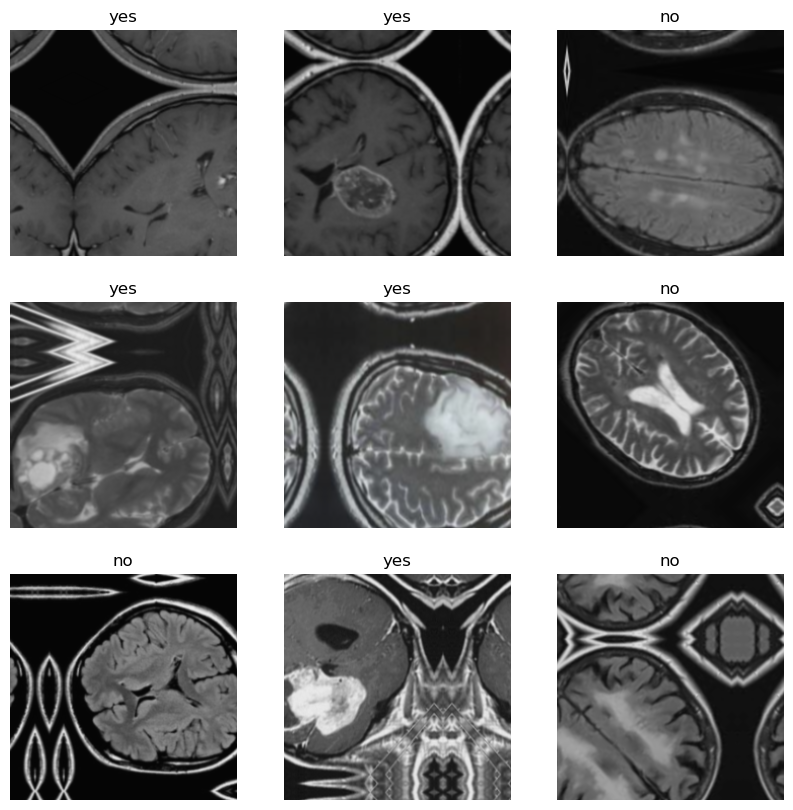

In [9]:


for images, labels in train_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9): #show 9 images
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

In [10]:
#normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
class_counts = {}
for _, label in train_ds.unbatch():
    label = int(label.numpy())
    class_counts[label] = class_counts.get(label, 0) + 1

#print("Class distribution:", class_counts)
#total_images = sum(class_counts.values())

In [13]:
# handle class imbalance

labels = [label.numpy() for _, label in train_ds.unbatch()]
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
#print("Class weights:", class_weights)


**Modelling**

In [14]:
model = models.Sequential([layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
                           layers.MaxPooling2D(2,2),
                           layers.Conv2D(64, (3,3), activation='relu'),
                           layers.MaxPooling2D(2,2),
                           layers.Flatten(),
                           layers.Dense(64, activation='relu'),
                           layers.Dropout(0.5),
                           layers.Dense(1, activation='sigmoid')])

model.compile(optimizer='adam',
              #loss='binary_crossentropy',
              loss=tf.keras.losses.BinaryFocalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 64)               

In [15]:
class_weights = {0: 1.5, 1: 1.0}
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs=20,
                    class_weight=class_weights)

Epoch 1/20
4/4 [==============================] - 92s 20s/step - loss: 0.2157 - accuracy: 0.6250 - val_loss: 0.1802 - val_accuracy: 0.2812
Epoch 2/20
4/4 [==============================] - 9s 2s/step - loss: 0.2089 - accuracy: 0.4297 - val_loss: 0.1739 - val_accuracy: 0.2812
Epoch 3/20
4/4 [==============================] - 8s 2s/step - loss: 0.2052 - accuracy: 0.3516 - val_loss: 0.1736 - val_accuracy: 0.2812
Epoch 4/20
4/4 [==============================] - 8s 2s/step - loss: 0.2051 - accuracy: 0.4531 - val_loss: 0.1733 - val_accuracy: 0.2812
Epoch 5/20
4/4 [==============================] - 8s 2s/step - loss: 0.2049 - accuracy: 0.5859 - val_loss: 0.1730 - val_accuracy: 0.7188
Epoch 6/20
4/4 [==============================] - 8s 2s/step - loss: 0.2050 - accuracy: 0.5938 - val_loss: 0.1725 - val_accuracy: 0.7188
Epoch 7/20
4/4 [==============================] - 8s 2s/step - loss: 0.2050 - accuracy: 0.6328 - val_loss: 0.1720 - val_accuracy: 0.7188
Epoch 8/20
4/4 [=======================

In [16]:
#transfer learning

base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze base

model1 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model1.compile(
    optimizer='adam',
    #loss='binary_crossentropy',
    loss=tf.keras.losses.BinaryFocalCrossentropy(),
    metrics=['accuracy']
)

model1.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,422,081
Trainable params: 164,097
Non-

In [17]:
history = model1.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
4/4 [==============================] - 18s 2s/step - loss: 0.3973 - accuracy: 0.5234 - val_loss: 0.3201 - val_accuracy: 0.7188
Epoch 2/20
4/4 [==============================] - 6s 2s/step - loss: 0.3662 - accuracy: 0.5938 - val_loss: 0.2135 - val_accuracy: 0.2812
Epoch 3/20
4/4 [==============================] - 7s 2s/step - loss: 0.2605 - accuracy: 0.5078 - val_loss: 0.1506 - val_accuracy: 0.7188
Epoch 4/20
4/4 [==============================] - 7s 2s/step - loss: 0.2221 - accuracy: 0.5547 - val_loss: 0.1506 - val_accuracy: 0.7188
Epoch 5/20
4/4 [==============================] - 7s 2s/step - loss: 0.1904 - accuracy: 0.5625 - val_loss: 0.1609 - val_accuracy: 0.7188
Epoch 6/20
4/4 [==============================] - 6s 2s/step - loss: 0.1878 - accuracy: 0.4844 - val_loss: 0.1550 - val_accuracy: 0.7188
Epoch 7/20
4/4 [==============================] - 7s 2s/step - loss: 0.1675 - accuracy: 0.6094 - val_loss: 0.1515 - val_accuracy: 0.7188
Epoch 8/20
4/4 [========================

In [18]:
# Unfreeze the last few layers of MobileNetV2
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile again with a lower learning rate
model1.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# training
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights
)


Epoch 1/10
4/4 [==============================] - 10s 3s/step - loss: 0.2040 - accuracy: 0.6328 - val_loss: 0.1679 - val_accuracy: 0.7188
Epoch 2/10
4/4 [==============================] - 8s 2s/step - loss: 0.2042 - accuracy: 0.6328 - val_loss: 0.1677 - val_accuracy: 0.7188
Epoch 3/10
4/4 [==============================] - 8s 2s/step - loss: 0.2045 - accuracy: 0.6328 - val_loss: 0.1675 - val_accuracy: 0.7188
Epoch 4/10
4/4 [==============================] - 8s 2s/step - loss: 0.2042 - accuracy: 0.6328 - val_loss: 0.1674 - val_accuracy: 0.7188
Epoch 5/10
4/4 [==============================] - 8s 2s/step - loss: 0.2046 - accuracy: 0.6328 - val_loss: 0.1673 - val_accuracy: 0.7188
Epoch 6/10
4/4 [==============================] - 8s 2s/step - loss: 0.2040 - accuracy: 0.6328 - val_loss: 0.1673 - val_accuracy: 0.7188
Epoch 7/10
4/4 [==============================] - 8s 2s/step - loss: 0.2039 - accuracy: 0.6328 - val_loss: 0.1671 - val_accuracy: 0.7188
Epoch 8/10
4/4 [========================

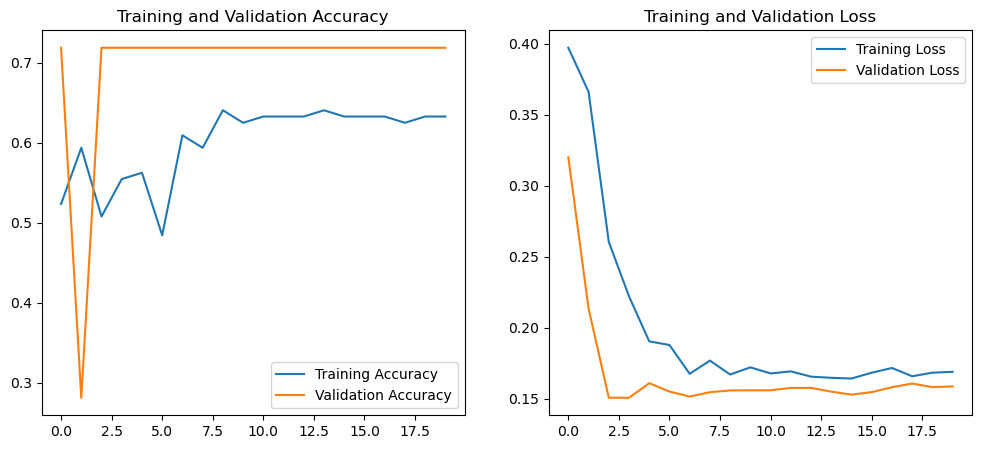

In [19]:

# extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [20]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.4f}')

# Classification report and confusion matrix
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = (model.predict(val_ds) > 0.5).astype("int32")

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)



2/2 [==============================] - 3s 371ms/step - loss: 0.1698 - accuracy: 0.6316
Test accuracy: 0.6316
1/1 [==============================] - 1s 611ms/step
              precision    recall  f1-score   support

          no       0.00      0.00      0.00         9
         yes       0.72      1.00      0.84        23

    accuracy                           0.72        32
   macro avg       0.36      0.50      0.42        32
weighted avg       0.52      0.72      0.60        32

Confusion Matrix:
 [[ 0  9]
 [ 0 23]]


In [21]:
test_loss, test_acc = model1.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.4f}')

# Classification report and confusion matrix
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = (model1.predict(val_ds) > 0.5).astype("int32")

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

2/2 [==============================] - 5s 827ms/step - loss: 0.6768 - accuracy: 0.6316
Test accuracy: 0.6316
1/1 [==============================] - 3s 3s/step
              precision    recall  f1-score   support

          no       0.00      0.00      0.00         9
         yes       0.72      1.00      0.84        23

    accuracy                           0.72        32
   macro avg       0.36      0.50      0.42        32
weighted avg       0.52      0.72      0.60        32

Confusion Matrix:
 [[ 0  9]
 [ 0 23]]


**Findings**

**CNN**
- Achieved ~57–69% accuracy on the test set.
- Class imbalance affected performance: “no tumor” class was poorly predicted (precision/recall 0).
- Confusion matrix shows model predicts the majority class (“tumor”).

**Transfer Learning(MobileNet V2)**
- Performance was worse  (~42% accuracy).
- Because of the tiny dataset (~128 images) is insufficient to fine-tune a pretrained network effectively.



**Limitations**

**Tiny dataset**

- With only ~128 images, CNN and transfer learning models are heavily constrained.
- Model cannot generalize well; high risk of overfitting.

**Class imbalance**

- “No tumor” class is underrepresented, causing the model to favor the majority class.
- Even with class_weight, model struggles to predict minority class accurately.

